# Preprocessing Input

In [1]:
import numpy as np
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from skimage.util import random_noise
from scipy.stats import norm
import cv2
np.random.seed(42)

- FILE_PATH: path to original input images
- IN_PATH: path to original input images with 256 x 256 and grayscale
- OUT_PATH: path to denoised output

*Import INPUT image into ./DATAImages if you want to use directly*<br>
*Import INPUT image into ./JPEGImages and run lower_resolution if you want to scale down input befor using it*
<br>
<br>
*Run noise_addition() to add noise into ./DATAImages and output to ./NOISEImages*

In [2]:
# INPUT folder (make sure all dataset are stored in this path)
FILE_PATH = 'JPEGImages/'

# INPUT folder (lower resolution and square dimension, not required)
IN_PATH = 'DATAImages/'

# OUTPUT folder 
OUT_PATH = 'NOISEImages/' 

# INPUT Dimension
SIZE = (256, 256)

def lower_resolution(PATH=FILE_PATH, OUT=IN_PATH, size = SIZE):
    ''' Lower resolution and Square Dimension '''
    # Create output directory, overwrite if exists
    shutil.rmtree(OUT, ignore_errors=True)
    os.makedirs(OUT)

    for i in os.listdir(PATH):
        # transform color to greyscale
        res_img = Image.open(os.path.join(PATH, i)).convert('L')
        res_img = np.array(res_img.resize(size, Image.ANTIALIAS))

        cv2.imwrite(os.path.join(OUT,i), res_img)

def noise_addition(PATH=IN_PATH, OUT=OUT_PATH, mode="gauss", grey = False, prob = 0.2):
    ''' Add noise to the dataset and store in a directory'''
    # Create output directory, overwrite if exists
    shutil.rmtree(OUT, ignore_errors=True)
    os.makedirs(OUT)
    
    for i in os.listdir(PATH):
        # Load the image
        if grey:
            img = cv2.imread(os.path.join(PATH,i), cv2.IMREAD_GRAYSCALE) 
        else:
            img = cv2.imread(os.path.join(PATH,i))
        
        out_img = 0
    
        if mode == "sp":
            # Add salt-and-pepper noise
            noise = random_noise(img, mode='s&p',amount=prob)
            out_img = np.array(255 * noise, dtype = 'uint8')
        elif mode == "gauss":
            # Add Gaussian noise
            gauss = np.random.normal(0,1,img.size)
            gauss = gauss.reshape(img.shape[0],img.shape[1])
            out_img = img + 10 * gauss
        cv2.imwrite(os.path.join(OUT,i), out_img)

# lower_resolution()
# noise_addition(grey=True, mode="sp", prob=0.01)


### Filter Salt&Pepper Noise out

In [3]:
def sp_noise(img, thre=32):
    ''' Filter out sp noise and output filtered image '''
    i1, i2, i3, i4 = np.ones(img.shape), np.ones(img.shape), np.ones(img.shape), np.ones(img.shape)
    img = img.astype(int)
    i1[:, :-1] = (np.abs(img[:, :-1] - img[:, 1:]) > thre).astype(int)
    i2[:, 1:] = (np.abs(img[:, 1:] - img[:, :-1]) > thre).astype(int)
    i3[:-1, :] = (np.abs(img[:-1, :] - img[1:, :]) > thre).astype(int)
    i4[1:, :] = (np.abs(img[1:, :] - img[:-1]) > thre).astype(int)
    isolated = (i1 + i2 + i3 + i4) >= 3

    print("{:.2f}% pixel mask out".format(isolated.sum() / (isolated.shape[0] * isolated.shape[1])))

    h, w = img.shape
    res = np.zeros((h, w))

    for i in range(h):
        for j in range(w):
            if isolated[i][j] == False:
                res[i][j] = img[i][j]
            else:
                neighboor = []
                if i > 0:
                    neighboor.append(img[i-1][j])
                if i < h - 1:
                    neighboor.append(img[i+1][j])
                if j > 0:
                    neighboor.append(img[i][j-1])
                if j < w - 1:
                    neighboor.append(img[i][j+1])
                
                if len(neighboor) == 2:
                    res[i][j] = (neighboor[0] + neighboor[1]) / 2
                elif len(neighboor) == 3:
                    res[i][j] = neighboor[1]
                elif len(neighboor) == 4:
                    neighboor.sort()
                    res[i][j] = (neighboor[1] + neighboor[2]) / 2
                else: 
                    import ipdb; ipdb.set_trace()
                    
    res = res.astype(np.uint8)

    return res


### Load Gaussian Noise Image
*You may change file path*

(500, 281)
(500, 281)


(-0.5, 499.5, 280.5, -0.5)

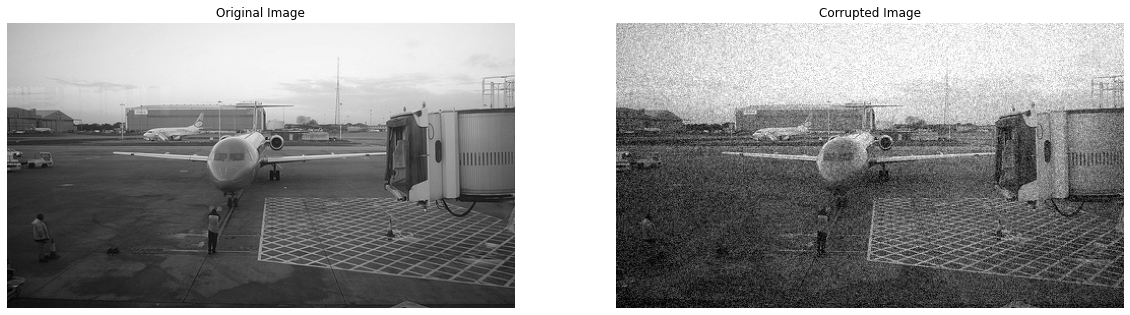

In [4]:
# Load the images.
orig_img = Image.open("DATAImages/00001.jpeg").convert('L')
corr_img = Image.open("NOISEImages/00001_gauss.jpeg")
print(orig_img.size)
print(corr_img.size)

# Convert to arrays.
Uorig = np.array(orig_img)
Ucorr = np.array(corr_img)

fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(orig_img, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(corr_img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Corrupted Image")
ax[1].axis('off')

0.13% pixel mask out


(-0.5, 499.5, 280.5, -0.5)

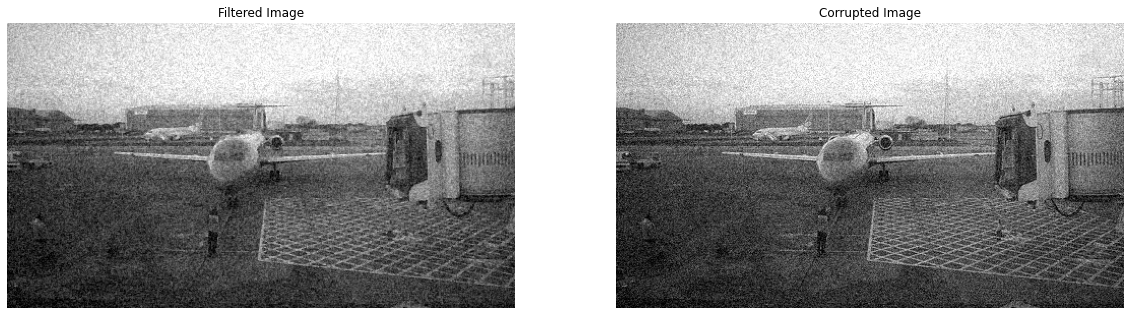

In [5]:
K = sp_noise(Ucorr)

fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(K, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Filtered Image")
ax[0].axis('off')
ax[1].imshow(Ucorr, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Corrupted Image")
ax[1].axis('off')

### Load Salt&Pepper Noise Image

(500, 281)
(500, 281)


(-0.5, 499.5, 280.5, -0.5)

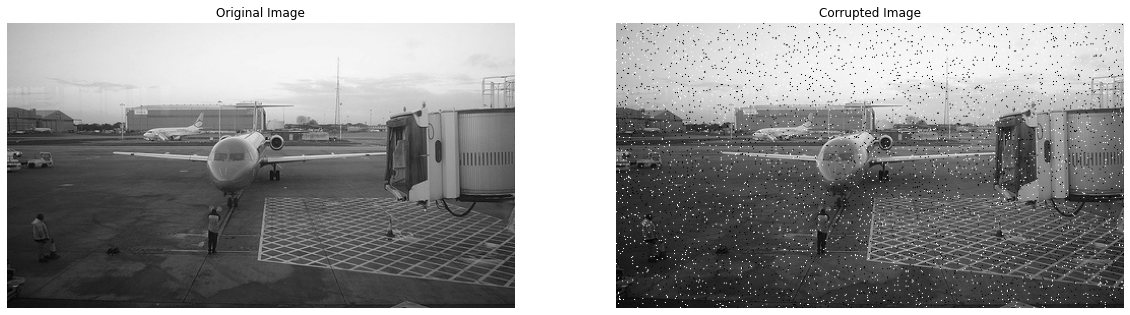

In [6]:
# Load the images.
_orig_img = Image.open("DATAImages/00001.jpeg").convert('L')
_corr_img = Image.open("NOISEImages/00001_sp.jpeg")
print(_orig_img.size)
print(_corr_img.size)

# Convert to arrays.
_Uorig = np.array(_orig_img)
_Ucorr = np.array(_corr_img)

fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(_orig_img, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(_corr_img, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Corrupted Image")
ax[1].axis('off')

0.05% pixel mask out


(-0.5, 499.5, 280.5, -0.5)

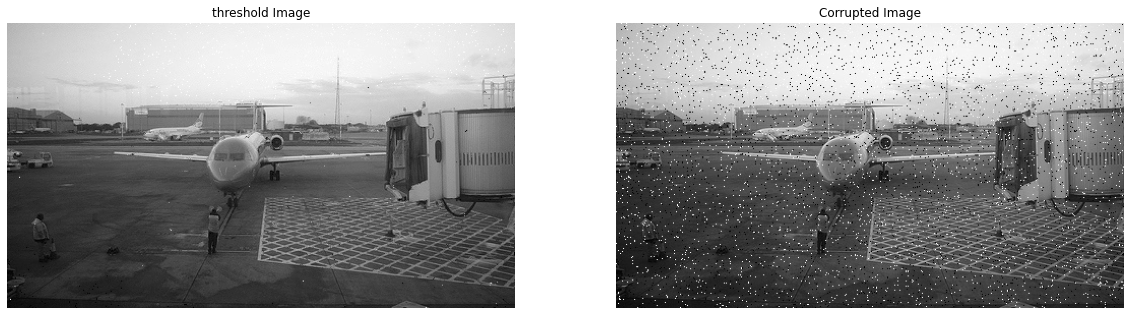

In [7]:
K = sp_noise(_Ucorr)

fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(K, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("threshold Image")
ax[0].axis('off')
ax[1].imshow(_Ucorr, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Corrupted Image")
ax[1].axis('off')

# Experiment

In [8]:

def _denoise(img, lam=1, eps = 10, thre = 50):
    ''' OBJ = Fidelity term + Lambda * Total variation of gradient '''
    ''' Constraint: '''
    var = cp.Variable(img.shape)

    # threshold term
    # known_mask, noise_mask = threshold(img, thre=30)
    noise_rm = sp_noise(img, thre = thre)

    # fidelity term
    fid = 0.5 * cp.sum_squares(var - img)

    # regularization term
    reg = cp.tv(var)

    # objective
    obj =  cp.Minimize(reg + lam * fid)
    # obj =  cp.Minimize(reg)
    constraints = [cp.abs(noise_rm.astype(int) - var) <= eps]
    # obj = cp.Minimize(cp.tv(var))
    # constraints = [cp.multiply(known_mask, var) == cp.multiply(known_mask, img)]
    prob = cp.Problem(obj, constraints = constraints)
    prob.solve(verbose = True, solver = 'SCS')

    return var.value


In [9]:
result =  _denoise(Ucorr, lam=0.01, eps=20, thre=32)

0.13% pixel mask out
                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Mar 12 07:03:05 PM: Your problem has 140500 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 12 07:03:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 12 07:03:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 12 07:03:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 12 07:03:05 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 12 07:03:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr 

Diff 2224800
Improvement 1120676


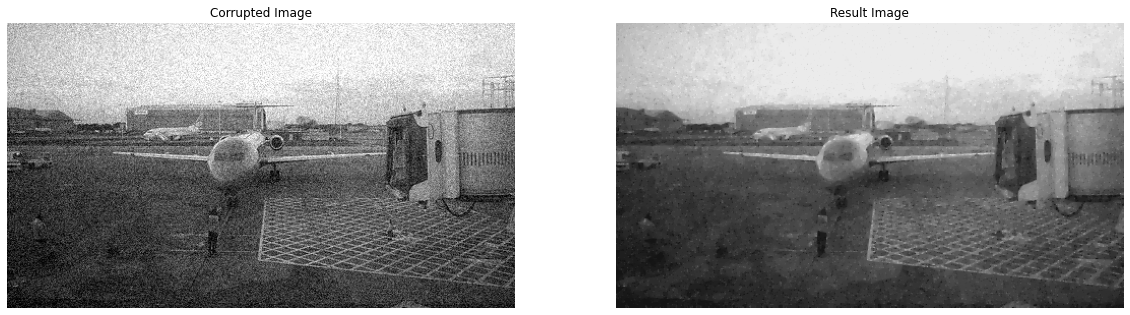

In [10]:
# Compare image.
fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(Ucorr, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Corrupted Image")
ax[0].axis('off')
ax[1].imshow(result, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Result Image")
ax[1].axis('off')

print('Diff', np.sum(abs(Ucorr.astype(int) - Uorig.astype(int))))
print('Improvement', np.sum(abs(result.astype(int) - Uorig.astype(int))))

In [11]:
_result = _denoise(_Ucorr, lam=2, eps=2)

0.03% pixel mask out
                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Mar 12 07:04:55 PM: Your problem has 140500 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 12 07:04:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 12 07:04:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 12 07:04:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 12 07:04:55 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 12 07:04:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr 

In [ ]:
# Compare image.
fig, ax = plt.subplots(1, 2,figsize=(20, 20))
ax[0].imshow(_Ucorr, cmap='gray', vmin=0, vmax=255)
ax[0].set_title("Corrupted Image")
ax[0].axis('off')
ax[1].imshow(_result, cmap='gray', vmin=0, vmax=255)
ax[1].set_title("Result Image")
ax[1].axis('off')

print('Diff', np.sum(abs(_Ucorr.astype(int) - _Uorig.astype(int))))
print('Improvement', np.sum(abs(_result.astype(int) - _Uorig.astype(int))))

Diff 901746
Improvement 268456
